<a href="https://colab.research.google.com/github/David-Smirnoff/NN_Classif_Hand_Hygiene/blob/main/5_sensores_RNN_Classification_Hand_hygiene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import warnings
import os
import json
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM


from sklearn.metrics import accuracy_score
from tensorflow import keras
from math import sin, cos, pi, sqrt, exp
from numpy import array
from numpy.linalg import norm
%matplotlib widget
warnings.filterwarnings('ignore')

In [ ]:
from sklearn import metrics
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers,layers

In [ ]:

# Specify the path to your JSON file
json_file_path1 = r'C:\Users\Win10\Desktop\I C\Programas\NN\Data Higiene de manos\train.json'
json_file_path2= r'C:\Users\Win10\Desktop\I C\Programas\NN\Data Higiene de manos\validation.json'
json_file_path3 = r'C:\Users\Win10\Desktop\I C\Programas\NN\Data Higiene de manos\test.json'

# Open the JSON file and load its contents
#TRAIN
with open(json_file_path1, 'r') as file:
    df_train = json.load(file)
df_train = pd.DataFrame.from_dict(df_train)
df_train = df_train.rename(columns={'event_classifier': 'Class'})
sub_columns_train = pd.DataFrame(df_train['Timestamps'].to_dict()).columns  #Access the sub-column names train

#VALIDATION
with open(json_file_path2, 'r') as file:
    df_validation = json.load(file)
df_validation = pd.DataFrame.from_dict(df_validation)
df_validation = df_validation.rename(columns={'event_classifier': 'Class'})
sub_columns_validation = pd.DataFrame(df_validation['Timestamps'].to_dict()).columns  #Access the sub-column names validation

#TEST
with open(json_file_path3, 'r') as file:
    df_test = json.load(file)
df_test = pd.DataFrame.from_dict(df_test)
df_test = df_test.rename(columns={'event_classifier': 'Class'})
sub_columns_test= pd.DataFrame(df_test['Timestamps'].to_dict()).columns  #Access the sub-column names test

# Concatenate the DataFrames in order
df = pd.concat([df_train, df_validation, df_test])
mean_columns=df.columns   # Access the mean-column names. All the mean columns are the same   AKA: the sensors names
sub_columns = pd.DataFrame(df['Timestamps'].to_dict()).columns  #Access the sub-column names  AKA: the events

# Display the concatenated DataFrame
# print((sub_columns_train))
# print((sub_columns_validation))
# print((sub_columns_test))
# print((mean_columns),(sub_columns))


events_quantity=len(df[mean_columns[5]])
points_quantity=len(df['Timestamps'][sub_columns[0]])
sensor_quantity=len(mean_columns)

print(sensor_quantity,points_quantity,events_quantity, mean_columns)


# Take a random sample from the data frame
#random.seed(40)
#df_final_test = df.sample(n=10)
# Drop the sampled data from the original data frame
#df = df.drop(df_final_test.index)


13 60 517 Index(['Timestamps', 'sgp30_EtOH_[au]', 'sgp30_H2_[au]', 'tgs8100_R_[Ohms]',
       'tgs2600_R_[Ohms]', 'ccs811_R_[Ohms]', 'tag_R_[Ohms]', 'temp_[C]',
       'rh_[%]', 'time_last_event_[s]', '#events_last1h', '#events_last2h',
       'Class'],
      dtype='object')



![separador](https://i.imgur.com/4gX5WFr.png)

# Características:
##### 13 Sensores/// 517 eventos/// Intervalos de tiempo de 300 seg, tomados cada 5 seg (60 features)

![Captura de pantalla 2023-06-09 093808.png](<attachment:Captura de pantalla 2023-06-09 093808.png>)

![separador](https://i.imgur.com/4gX5WFr.png)


In [ ]:
# plt.figure(figsize=(4,2.27))
# plt.hist(df['Class'])  #Bins es el ancho de la columna
# plt.xlabel("Class 0: Bad Hygiene               Clase 1: Good Hygiene")
# plt.tight_layout()
# plt.show()

![separador](https://i.imgur.com/4gX5WFr.png)

### Aumento Clase 2
![separador](https://i.imgur.com/4gX5WFr.png)


Cada clase tiene elementos: 182 335
Ahora cada clase tiene elementos: 282 335


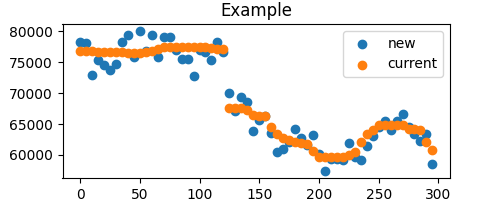

In [ ]:
df_class0 = df[df['Class'] == 0]
df_class1 = df[df['Class'] == 1]
print('Cada clase tiene elementos:',len(df_class0),len(df_class1))
# Numero para balancear la data
selected_sensors=['sgp30_EtOH_[au]', 'sgp30_H2_[au]', 'tgs8100_R_[Ohms]', 'tgs2600_R_[Ohms]', 'ccs811_R_[Ohms]', 'tag_R_[Ohms]', 'temp_[C]','rh_[%]']
# Creo un DataFrame para almacenar la data balanceada
balanced_df = pd.DataFrame(columns=df.columns)

aumento=100
for buf in range(0,aumento):
    # Copy the row
    new_row = df_class0.sample(n=1)
    current_row=new_row.copy()
    # Add Gaussian noise to selected features
    for sensor in selected_sensors:
        noise=np.random.normal(0,0.025,points_quantity)
        new_row[sensor][0] =[x *(1+ y) for x, y in zip(new_row[sensor][0], noise)]
    if buf==60:
        plt.figure(figsize=(5,2))
        t=np.arange(0, points_quantity * 5, 5)
        for sensor in range(2,3):
            plt.scatter(t,new_row[mean_columns[5]][0],label='new')
            plt.scatter(t,current_row[mean_columns[5]][0],label='current')
            plt.title('Example')
            plt.xlabel('t [s]')
            plt.legend()
    # Append the modified row to the balanced data frame
    balanced_df = balanced_df.append(new_row, ignore_index=True)

# Concatenate the balanced class 2 data frame with the original class 1 data frame
balanced_df = pd.concat([df, balanced_df], axis=0,ignore_index=True)
balanced_df = balanced_df.sample(frac=1)#, random_state=42)  # frac=1 shuffles all rows, random_state for reproducibility

df_class0= balanced_df[balanced_df['Class'] == 0]
df_class1 = balanced_df[balanced_df['Class'] == 1]
mean_columns2=balanced_df.columns   # Access the mean-column names. All the mean columns are the same   AKA: the sensors names
sub_columns2 = pd.DataFrame(balanced_df['Timestamps'].to_dict()).columns  #Access the sub-column names  AKA: the events
events_quantity=len(balanced_df[mean_columns[5]])
points_quantity=len(balanced_df['Timestamps'][sub_columns2[0]])

print('Ahora cada clase tiene elementos:',len(df_class0) , len(df_class1))
# plt.figure(figsize=(4,2.27))
# plt.hist(balanced_df['Class'])  #Bins es el ancho de la columna
# plt.xlabel("Class 0: Bad Hygiene               Clase 1: Good Hygiene")
# plt.tight_layout()
# plt.show()
# print(sensor_quantity,points_quantity,events_quantity, mean_columns)


![separador](https://i.imgur.com/4gX5WFr.png)

# Sensores:

##### Estacionarios: SGP30_EtOH (arbitrary units); SGP30_H2 (a.u.); TGS8100 R (Ω); TGS2600 R (Ω); CCS811 R (Ω)
##### HYT939 Temperature/ humidity  T (◦C) r.h. (%) stationary
##### Portable: TGS8100 R (Ω) tag   <span style="color:red">No me va a importar.</span>
![separador](https://i.imgur.com/4gX5WFr.png)


In [ ]:
# #sensor=1  #(0<=sensor<=8)
# event=np.arange(0,616,1); t=np.arange(0, points_quantity * 5, 5);   #choose event;
# event=294
# plt.figure(figsize=(6.5, 3))
# for sensor in range(1,7):
#     plt.plot(t,balanced_df[mean_columns[sensor]][sub_columns2[event]],label=f'{mean_columns[sensor]}')
# plt.title(f'event {balanced_df[mean_columns[0]][sub_columns2[event]][0]}')
# plt.xlabel('t [s]')
# plt.legend()
# # plt.figure(figsize=(8, 4))
# # for sensor in range(9,12):
# #     plt.plot(event,df[mean_columns[sensor]][event],label= f'{mean_columns[sensor]}' )
# # plt.xlabel('event')
# # plt.legend()


![separador](https://i.imgur.com/4gX5WFr.png)

# Prueba 5 Sensores

### Red Recursiva

![separador](https://i.imgur.com/4gX5WFr.png)


##### Defino PlotLoss, PlotAcc, Plot_Conf_Matrix

In [ ]:
def plotLoss(result, extra_title=""):
    loss = result.history['loss']
    val_loss = result.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(4,4))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss '+extra_title)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Square Error')
    plt.legend()
    plt.show()

def plotAcc(result, extra_title=""):
    acc = result.history['sparse_categorical_accuracy']
    val_acc = result.history['val_sparse_categorical_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(4,4))
    plt.plot(epochs, acc, 'y', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation acc '+extra_title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0,1])
    plt.legend()
    plt.show()

def plot_conf_matrix(results, X, Y, extra_title=""):
    cm = metrics.confusion_matrix(Y, results)
    print(cm)
    plt.figure(1)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['B Hygiene','G Higyene'])
    disp.plot()
    plt.title("Matriz de confusion "+extra_title)
    plt.show()


![separador](https://i.imgur.com/4gX5WFr.png)

### Normalizo data y creo modelo

![separador](https://i.imgur.com/4gX5WFr.png)

In [ ]:
# Resume
selected_sensor = mean_columns[1:6]
selected_sensor = selected_sensor.tolist()
print(selected_sensor)
Y = balanced_df["Class"]
Y = Y.astype(np.int64) # Convertir la variable a un tipo de datos compatible

X = np.zeros((len(balanced_df), len(selected_sensor), 60))  # Inicializar X con ceros

for i, sensor in enumerate(selected_sensor):   #tanto el índice como el elemento actual en cada iteración
    x_curr = balanced_df[sensor]  # Acceder a la columna del sensor actual
    x_curr = pd.DataFrame(x_curr.tolist())
    scaler = StandardScaler().fit(x_curr)
    x_curr = scaler.transform(x_curr)
    X[:, i, :] = x_curr
print('X',X[0:2].shape)

# Define the model
def creo_modelo(input_shape):
    model = keras.Sequential()
    model.add(layers.Bidirectional(layers.LSTM(16, activation='tanh', return_sequences=True), input_shape=input_shape))  #return_sequences=True to the first Bidirectional layer, you ensure that it outputs a 3-dimensional tensor (batch_size, sequence_length, num_features)
    model.add(Dropout(0.10))
    model.add(layers.Bidirectional(layers.LSTM(4, activation='tanh')))
    model.add(Dropout(0.10))

    model.add(layers.Dense(10, activation='relu'))
    model.add(Dropout(0.10))
    model.add(layers.Dense(2, activation='softmax'))
    return model

input_shape = (len(selected_sensor), 60)
model = creo_modelo(input_shape)
model.summary()

['sgp30_EtOH_[au]', 'sgp30_H2_[au]', 'tgs8100_R_[Ohms]', 'tgs2600_R_[Ohms]', 'ccs811_R_[Ohms]']
X (2, 5, 60)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 32)            9856      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 8)                1184      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 10)                90        
             

In [ ]:


def genero_modelo_y_entreno(X, Y, early=False, epochs=60, bs=64, val_frac=0.2, vb=1):

    #Para HOLD OUT sacar random state
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.1)  ##  NORMALIZO ANTES

    model = creo_modelo(input_shape = (len(selected_sensor), 60))
    opt = tf.keras.optimizers.Adam(learning_rate=0.05)
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["sparse_categorical_accuracy"])

    callbacks = []
    if early:
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        callbacks.append(early_stopping)
    else:
        #It monitors the validation loss and reduces the learning rate by a factor of 0.1 if the validation loss does not improve for 5 consecutive epochs.
        #The minimum learning rate is set to 0.0001.
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, min_lr=0.0001);callbacks.append(reduce_lr)


    result = model.fit(X_train, Y_train, epochs=epochs, batch_size=bs, validation_split=val_frac, callbacks=callbacks, verbose=vb)

    graph = 1
    if graph == 1:
        plotLoss(result)
        plotAcc(result)

    test_loss, test_acc = model.evaluate(X_test, Y_test)
    Accuracy.append(test_acc)
    print(buf+1,f"Test accuracy: {test_acc:.2f}")

    pred = model.predict(X_test)
    res = [np.argmax(num) for num in pred]
    plot_conf_matrix(res, X_test, Y_test)



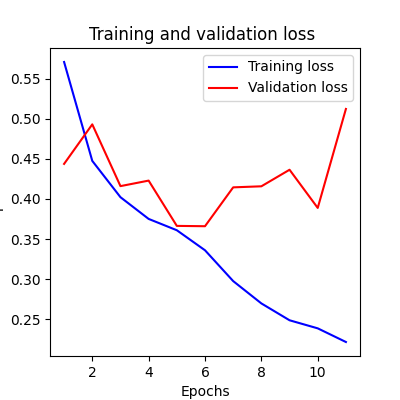

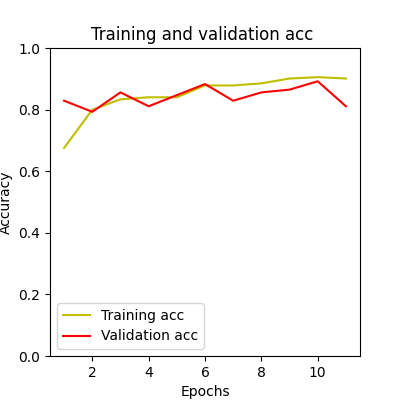

2/2 [==============================] - 0s 7ms/step - loss: 0.6900 - sparse_categorical_accuracy: 0.7903
1 Test accuracy: 0.79
2/2 [==============================] - 3s 5ms/step
[[21  4]
 [ 9 28]]


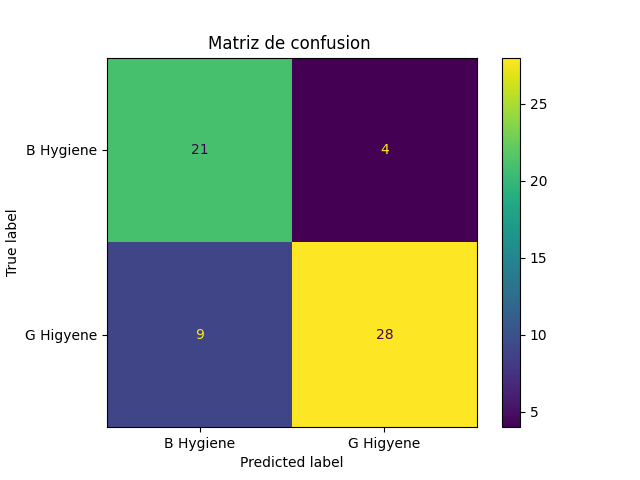

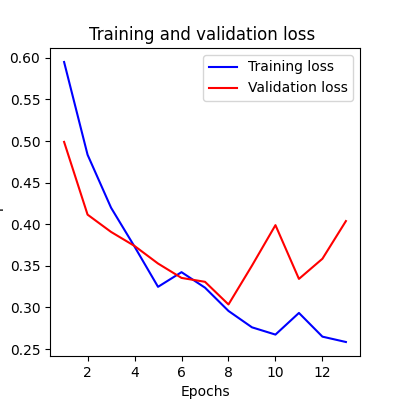

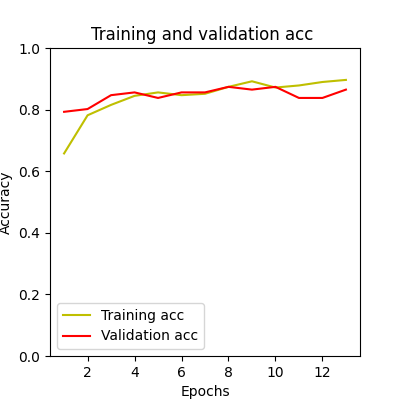

2/2 [==============================] - 0s 9ms/step - loss: 0.3757 - sparse_categorical_accuracy: 0.8871
2 Test accuracy: 0.89
2/2 [==============================] - 4s 8ms/step
[[19  2]
 [ 5 36]]


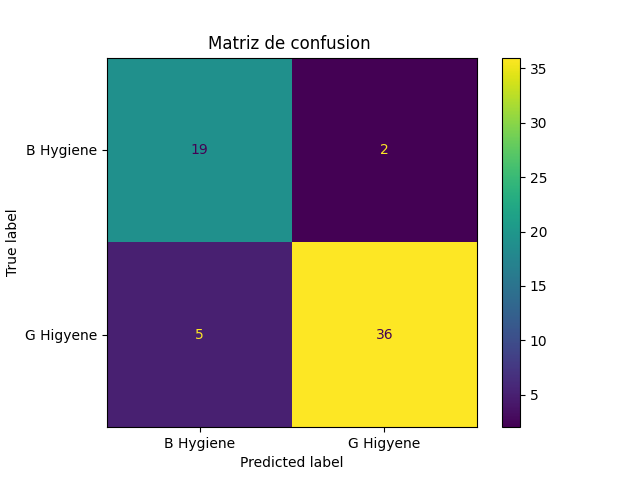

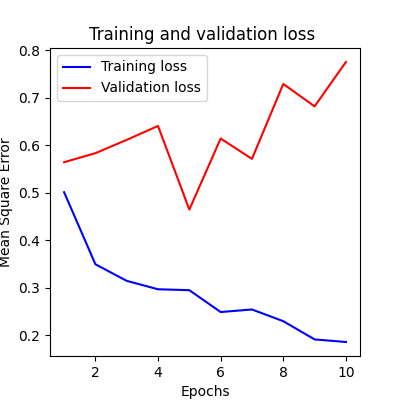

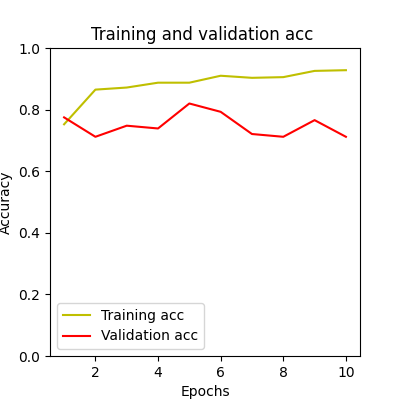

2/2 [==============================] - 0s 16ms/step - loss: 0.6735 - sparse_categorical_accuracy: 0.8387
3 Test accuracy: 0.84
2/2 [==============================] - 2s 6ms/step
[[26  1]
 [ 9 26]]


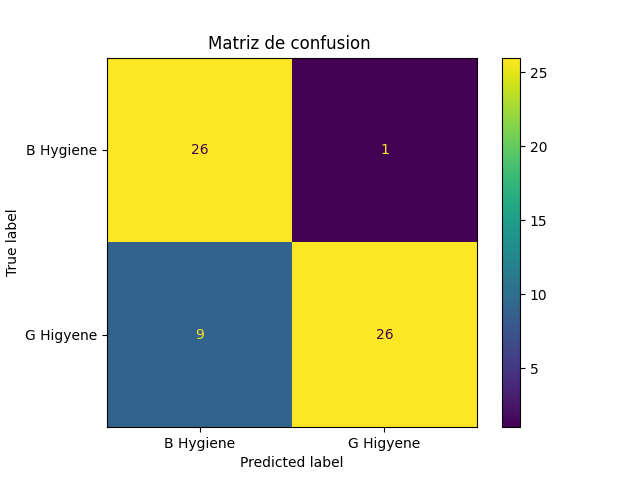

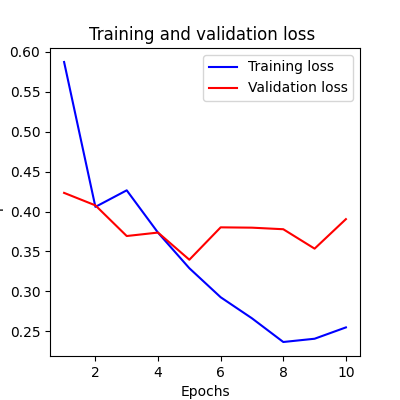

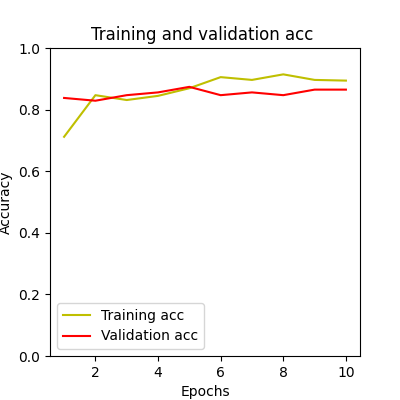

2/2 [==============================] - 0s 7ms/step - loss: 0.6406 - sparse_categorical_accuracy: 0.8387
4 Test accuracy: 0.84
2/2 [==============================] - 5s 3ms/step
[[15  2]
 [ 8 37]]


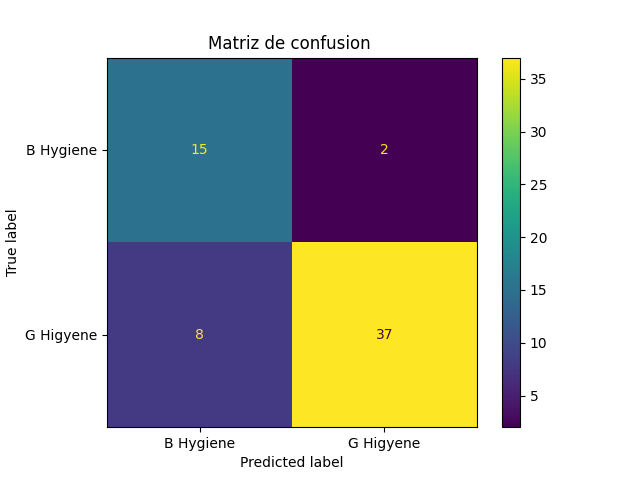

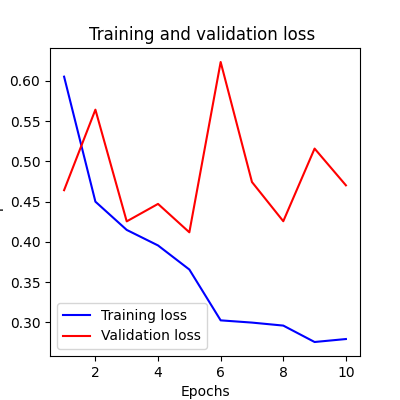

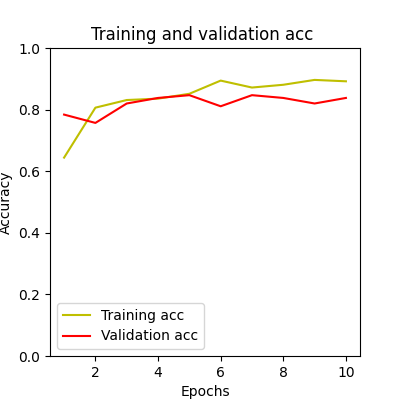

2/2 [==============================] - 0s 16ms/step - loss: 0.2747 - sparse_categorical_accuracy: 0.8548
5 Test accuracy: 0.85
2/2 [==============================] - 2s 16ms/step
[[20  2]
 [ 7 33]]


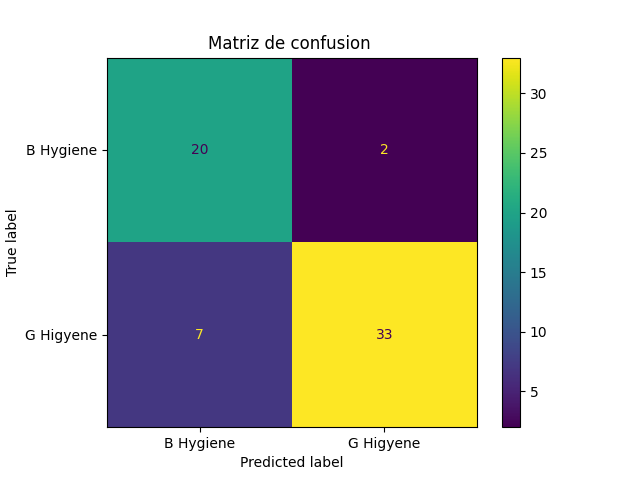

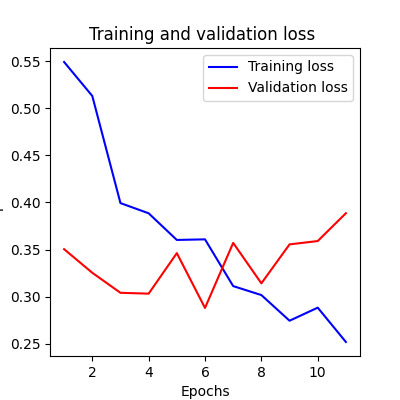

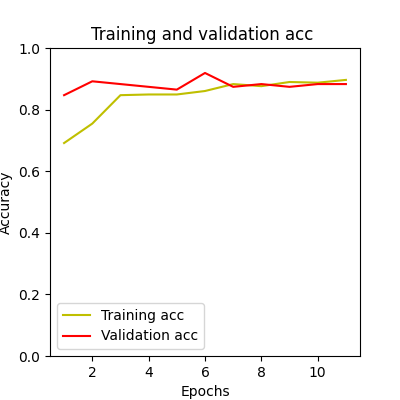

2/2 [==============================] - 0s 5ms/step - loss: 0.5532 - sparse_categorical_accuracy: 0.7742
6 Test accuracy: 0.77
2/2 [==============================] - 1s 0s/step
[[22  8]
 [ 6 26]]


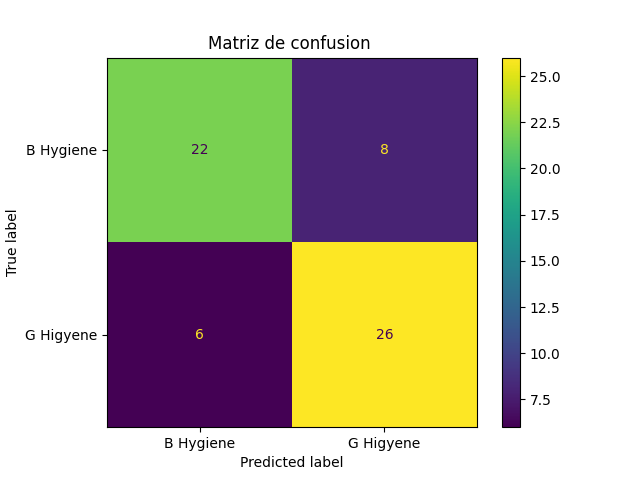

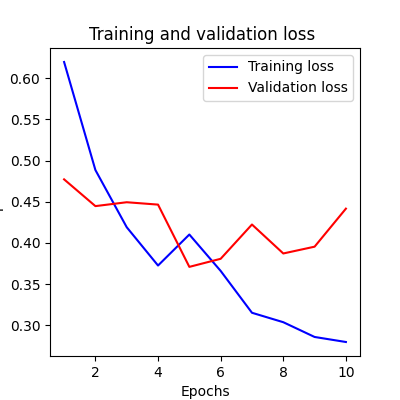

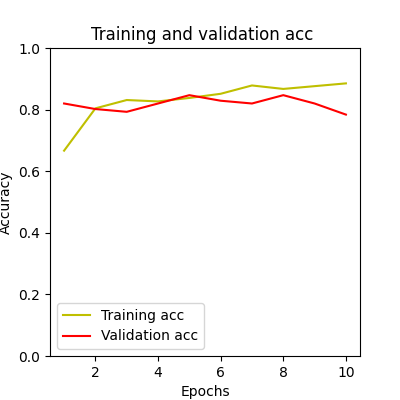

2/2 [==============================] - 0s 0s/step - loss: 0.2940 - sparse_categorical_accuracy: 0.8871
7 Test accuracy: 0.89
2/2 [==============================] - 1s 0s/step
[[32  1]
 [ 6 23]]


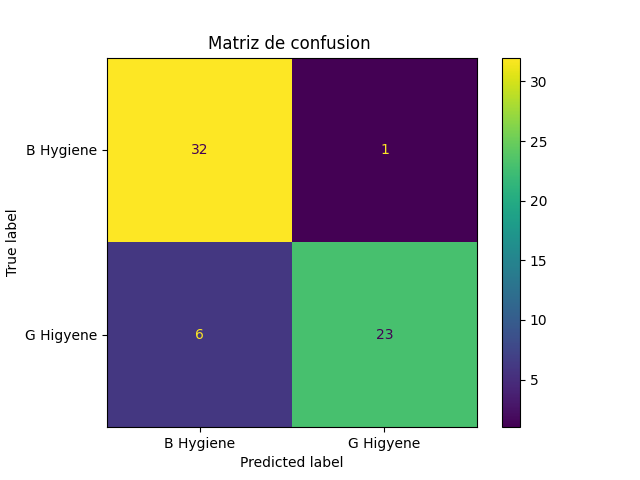

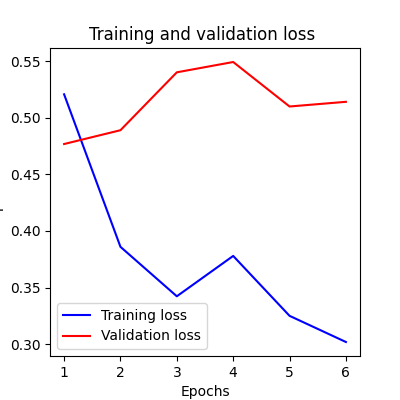

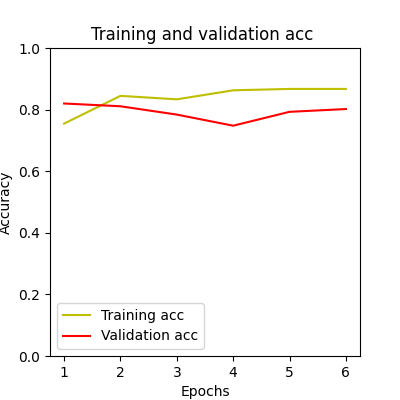

2/2 [==============================] - 0s 6ms/step - loss: 0.3034 - sparse_categorical_accuracy: 0.9032
8 Test accuracy: 0.90
2/2 [==============================] - 2s 5ms/step
[[22  2]
 [ 4 34]]


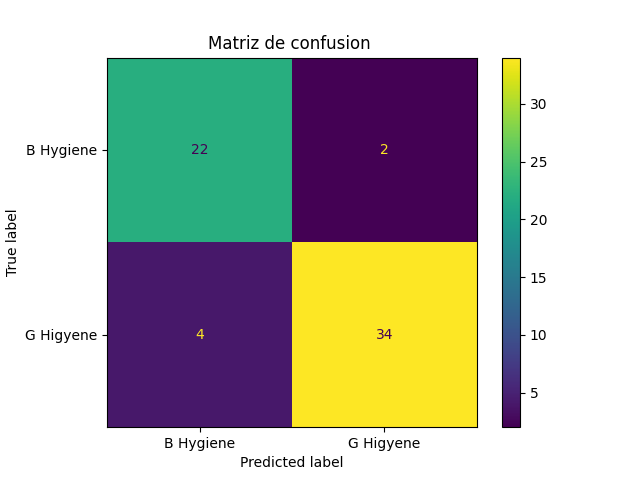

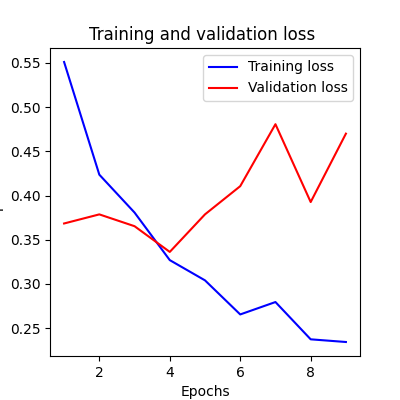

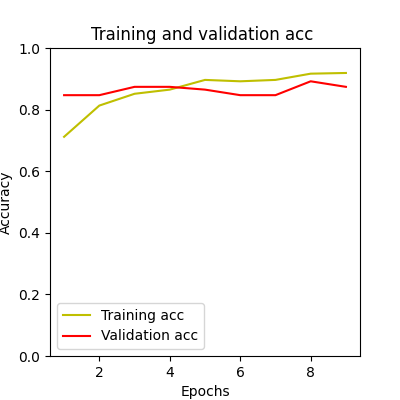

2/2 [==============================] - 0s 7ms/step - loss: 0.5571 - sparse_categorical_accuracy: 0.7742
9 Test accuracy: 0.77
2/2 [==============================] - 3s 6ms/step
[[24  7]
 [ 7 24]]


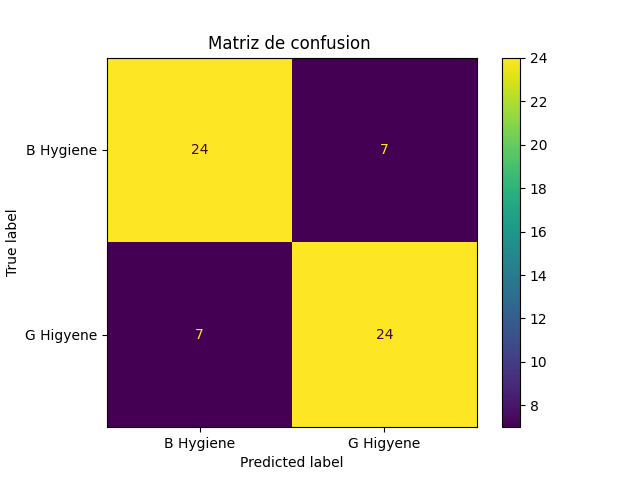

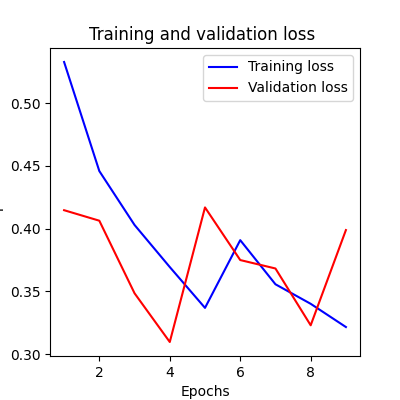

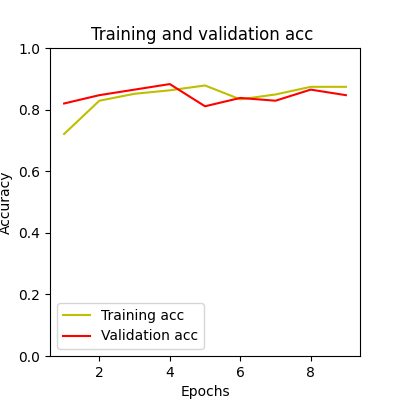

2/2 [==============================] - 0s 10ms/step - loss: 0.2817 - sparse_categorical_accuracy: 0.8710
10 Test accuracy: 0.87
2/2 [==============================] - 2s 5ms/step
[[17  7]
 [ 1 37]]


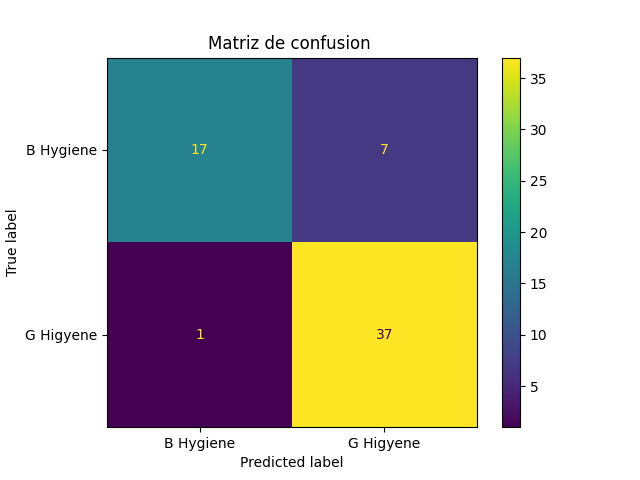

[0.7903226017951965, 0.8870967626571655, 0.8387096524238586, 0.8387096524238586, 0.8548387289047241, 0.774193525314331, 0.8870967626571655, 0.9032257795333862, 0.774193525314331, 0.8709677457809448]
Mean: Standard Deviation: 84 4.6


In [ ]:
Accuracy=[]
n=10
for buf in range(0,n):
    genero_modelo_y_entreno(X,Y, early=True, epochs=60, bs=64, val_frac=0.2,vb=0)

mean = np.mean(Accuracy)
std_dev = np.std(Accuracy)
print(Accuracy)
print("Mean:", "Standard Deviation:" ,f"{mean*100:.0f}",f"{ std_dev*100:.1f}")